In [ ]:
from dataset import MultisensorDataset, DatasetConfig
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
import logging

logging.basicConfig(level=logging.INFO)

In [ ]:
config = DatasetConfig(
    parquet_path="exports_last_100_days/multisensor.parquet",
    meta_path="exports_last_100_days/multisensor.parquet.meta.json",
    devices=[1],
    metrics=["co2", "gas_resistance", "light", "voc_equivalent", "temperature", "humidity", "pressure"],
    # Predict only this metric while using all metrics as inputs
    # target_metric="co2",
    window_size=60,
    horizon=4,
    min_activity_ratio=0.08,
    min_activity_ratio_by_metric={
        "co2": 0.8,
        "gas_resistance": 0.8,
        "light": 0.4,
        "voc_equivalent": 0.2,
        "temperature": 0.03,
    },
    fill="interpolate",
    fill_limit=30,
    normalize=True,
    require_full_windows=True,
    return_observation_mask=False,
    return_timestamps=False,
)

dataset = MultisensorDataset(config)
print("num windows:", len(dataset))

INFO:multisensor.dataset:Initialized dataset for 1 devices, 7 metrics
INFO:multisensor.dataset:Device 1: 143944 rows after resample (unfilled), 0.523 observed ratio


num windows: 23617


In [36]:
# Plot random windows
rng = np.random.default_rng(1110)
num_to_show = min(0, len(dataset))
indices = rng.choice(len(dataset), size=num_to_show, replace=False)

metric_to_idx = {name: i for i, name in enumerate(dataset._metric_names)}

for i, idx in enumerate(indices, start=1):
    sample = dataset[int(idx)]
    x = sample[0].numpy()  # (window, M)
    plt.figure(figsize=(12, 4))
    for name in dataset._metric_names:
        col = metric_to_idx[name]
        series = x[:, col]
        plt.plot(series, label=name)
    plt.title(f"Random window {i} (idx={int(idx)})")
    plt.xlabel("timestep")
    plt.ylabel("normalized value")
    plt.legend()
plt.show()

In [38]:
# Train/val split by device and DataLoaders
import math
import torch
from torch.utils.data import DataLoader, Subset

# Use GPU if available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", DEVICE)

# Build per-device temporal split to avoid leakage
VAL_RATIO = 0.2
train_indices = []
val_indices = []
for group_idx, starts in enumerate(dataset._device_start_indices):
    group_offset = dataset._device_offsets[group_idx]
    n_group = len(starts)
    if n_group == 0:
        continue
    split = int(math.floor(n_group * (1.0 - VAL_RATIO)))
    # first chunk for training, last chunk for validation
    train_indices.extend(range(group_offset, group_offset + split))
    val_indices.extend(range(group_offset + split, group_offset + n_group))

print(f"Train windows: {len(train_indices)}  Val windows: {len(val_indices)}")

# DataLoaders
BATCH_SIZE = 64
NUM_WORKERS = 0

train_set = Subset(dataset, train_indices)
val_set = Subset(dataset, val_indices)

train_loader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, drop_last=True)
val_loader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# Infer shapes (metrics vs actual input channels)
METRICS_ONLY = len(dataset._metric_names)
HORIZON = dataset.cfg.horizon
OUTPUT_DIM = 1 if dataset._target_col is not None else METRICS_ONLY
# Probe a batch to determine the true input dimension after encodings
probe_x, probe_y = next(iter(train_loader))
INPUT_DIM = int(probe_x.shape[-1])
print(f"METRICS_ONLY={METRICS_ONLY}, INPUT_DIM={INPUT_DIM}, HORIZON={HORIZON}, OUTPUT_DIM={OUTPUT_DIM}")


Using device: cpu
Train windows: 18893  Val windows: 4724
METRICS_ONLY=7, INPUT_DIM=12, HORIZON=4, OUTPUT_DIM=1


In [39]:
# LSTM encoder model for sequence-to-sequence forecasting
import math
import torch # use 0 in notebooks for portability
import torch.nn as nn

class Seq2SeqLSTM(nn.Module):
    def __init__(
        self,
        input_dim: int,
        horizon: int,
        output_dim: int,
        hidden_size: int = 128,
        num_layers: int = 2,
        dropout: float = 0.2,
        pool: str = "last",  # kept for API symmetry; not used
    ) -> None:
        super().__init__()
        self.horizon = horizon
        self.output_dim = output_dim
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.head = nn.Linear(hidden_size, horizon * output_dim)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, W, D)
        _, (h_n, _) = self.lstm(x)
        z = h_n[-1]  # (B, hidden_size)
        y = self.head(z)
        y = y.view(x.size(0), self.horizon, self.output_dim)
        return y

# Instantiate the model with probed INPUT_DIM
HIDDEN_SIZE = 16
NUM_LAYERS = 1
DROPOUT = 0.2

model = Seq2SeqLSTM(
    input_dim=INPUT_DIM,
    horizon=HORIZON,
    output_dim=OUTPUT_DIM,
    hidden_size=HIDDEN_SIZE,
    num_layers=NUM_LAYERS,
    dropout=DROPOUT,
).to(DEVICE)

sum_params = sum(p.numel() for p in model.parameters())
print(model.__class__.__name__, "parameters:", sum_params)


Seq2SeqLSTM parameters: 1988


In [40]:
# Training and validation loops
import time
import torch
import torch.nn.functional as F

def compute_metrics(y_true: torch.Tensor, y_pred: torch.Tensor):
    # y_true, y_pred: (B, H, C)
    mse = F.mse_loss(y_pred, y_true, reduction="mean").item()
    mae = F.l1_loss(y_pred, y_true, reduction="mean").item()
    rmse = mse ** 0.5
    return mse, rmse, mae

@torch.no_grad()
def evaluate(model: torch.nn.Module, loader, device: torch.device):
    model.eval()
    total_loss = 0.0
    total_batches = 0
    total_mse = 0.0
    total_rmse = 0.0
    total_mae = 0.0
    for batch in loader:
        x, y = batch
        x = x.to(device).float()
        y = y.to(device).float()
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y, reduction="mean")
        total_loss += loss.item()
        mse, rmse, mae = compute_metrics(y, y_hat)
        total_mse += mse
        total_rmse += rmse
        total_mae += mae
        total_batches += 1
    denom = max(1, total_batches)
    return {
        "loss": total_loss / denom,
        "mse": total_mse / denom,
        "rmse": total_rmse / denom,
        "mae": total_mae / denom,
    }

def train_one_epoch(model: torch.nn.Module, loader, optimizer, device: torch.device, max_norm: float = 1.0):
    model.train()
    total_loss = 0.0
    total_batches = 0
    for batch in loader:
        x, y = batch
        x = x.to(device).float()
        y = y.to(device).float()
        optimizer.zero_grad(set_to_none=True)
        y_hat = model(x)
        loss = F.mse_loss(y_hat, y, reduction="mean")
        loss.backward()
        if max_norm is not None and max_norm > 0:
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_loss += loss.item()
        total_batches += 1
    return total_loss / max(1, total_batches)

# Optimizer and (optional) scheduler
LR = 1e-3
WEIGHT_DECAY = 1e-3  # a bit stronger regularization to combat overfitting
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

# Optional cosine decay without warmup (simple)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)

print("Optimizer and scheduler ready")


Optimizer and scheduler ready


Epoch 01 | train_loss=0.31794 | val_loss=0.41637 | val_rmse=0.46306 | val_mae=0.41764 | time=10.4s
Epoch 02 | train_loss=0.02772 | val_loss=0.19735 | val_rmse=0.28923 | val_mae=0.25249 | time=10.2s
Epoch 03 | train_loss=0.01359 | val_loss=0.13636 | val_rmse=0.23896 | val_mae=0.20581 | time=9.8s
Epoch 04 | train_loss=0.00982 | val_loss=0.10626 | val_rmse=0.20978 | val_mae=0.17876 | time=9.0s
Epoch 05 | train_loss=0.00872 | val_loss=0.09314 | val_rmse=0.19654 | val_mae=0.16715 | time=8.0s
Epoch 06 | train_loss=0.00823 | val_loss=0.08220 | val_rmse=0.18887 | val_mae=0.16026 | time=8.5s


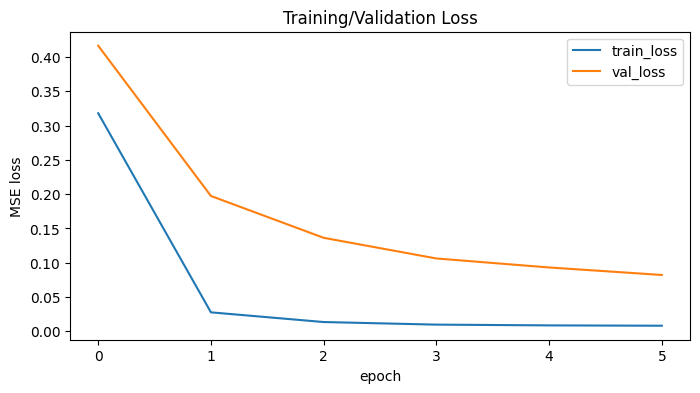

In [41]:
# Run training with simple early stopping
import numpy as np
import matplotlib.pyplot as plt

EPOCHS = 6
PATIENCE = 3
no_improve = 0
train_history = []
val_history = []

best_val = float("inf")
best_state = None

for epoch in range(1, EPOCHS + 1):
    start_time = time.time()
    train_loss = train_one_epoch(model, train_loader, optimizer, DEVICE)
    val_stats = evaluate(model, val_loader, DEVICE)
    scheduler.step()
    elapsed = time.time() - start_time

    train_history.append(train_loss)
    val_history.append(val_stats["loss"])

    print(f"Epoch {epoch:02d} | train_loss={train_loss:.5f} | val_loss={val_stats['loss']:.5f} | val_rmse={val_stats['rmse']:.5f} | val_mae={val_stats['mae']:.5f} | time={elapsed:.1f}s")

    if val_stats["loss"] < best_val - 1e-6:
        best_val = val_stats["loss"]
        best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch} (no improvement for {PATIENCE} epochs)")
            break

# Load best
if best_state is not None:
    model.load_state_dict(best_state)

# Plot losses
plt.figure(figsize=(8,4))
plt.plot(train_history, label="train_loss")
plt.plot(val_history, label="val_loss")
plt.xlabel("epoch")
plt.ylabel("MSE loss")
plt.title("Training/Validation Loss")
plt.legend()
plt.show()


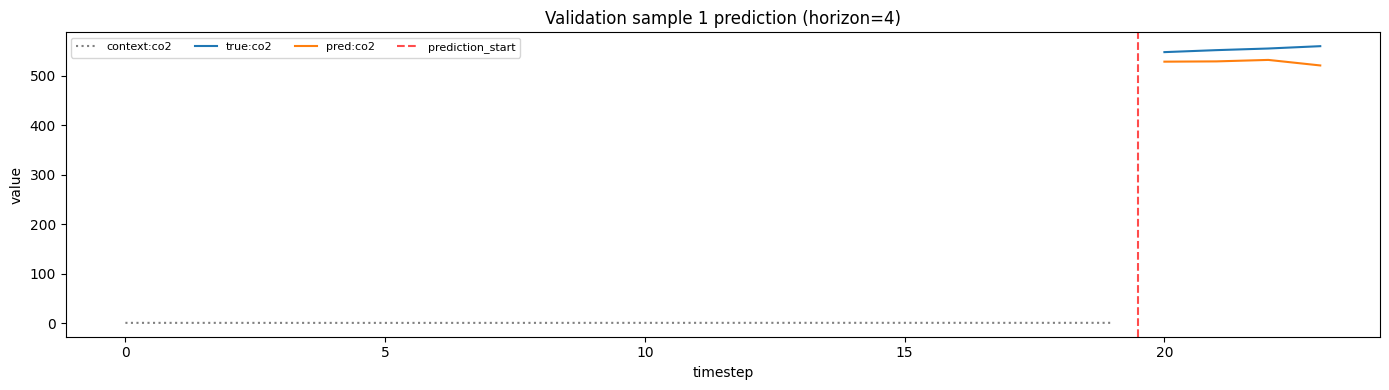

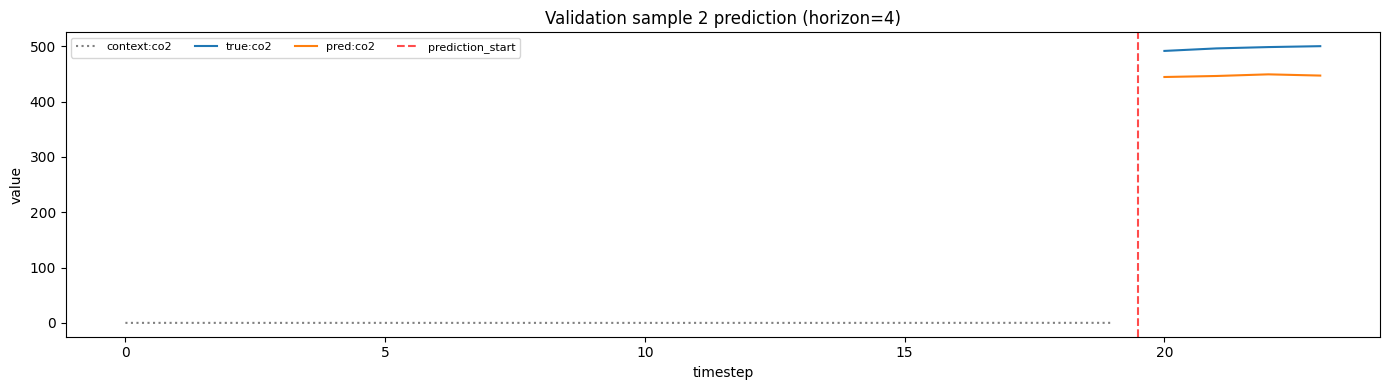

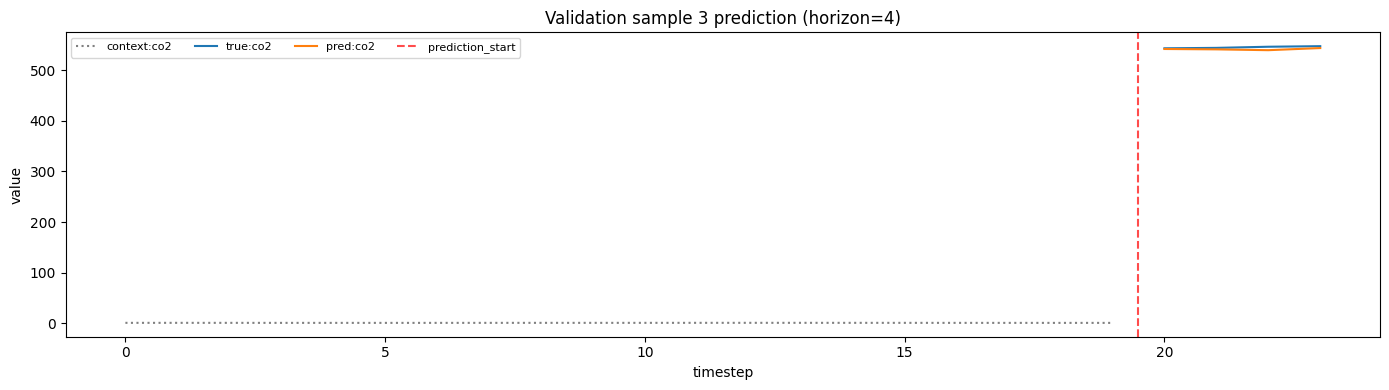

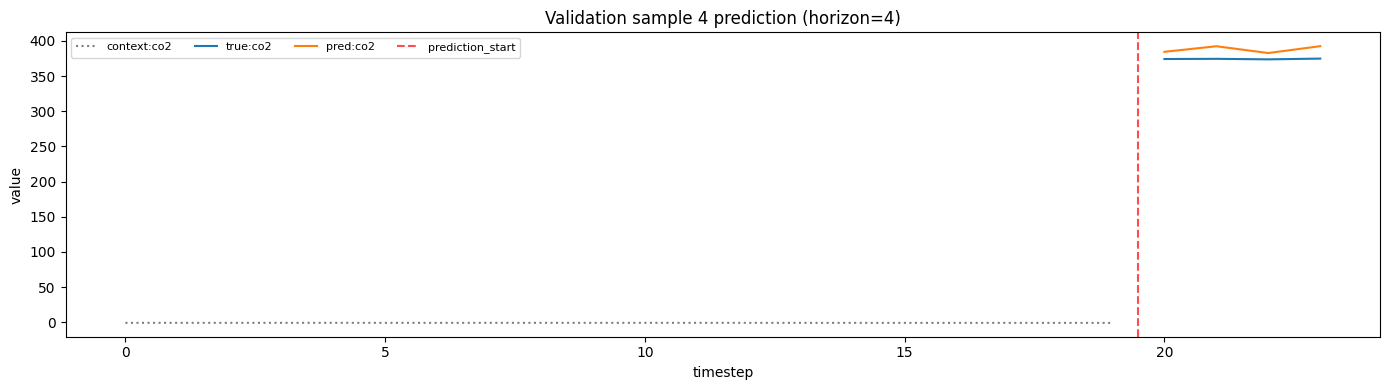

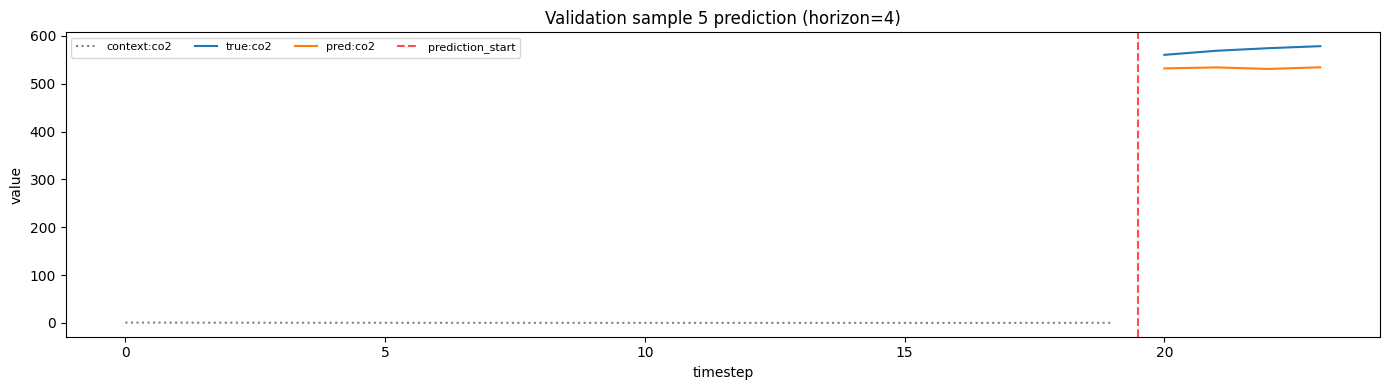

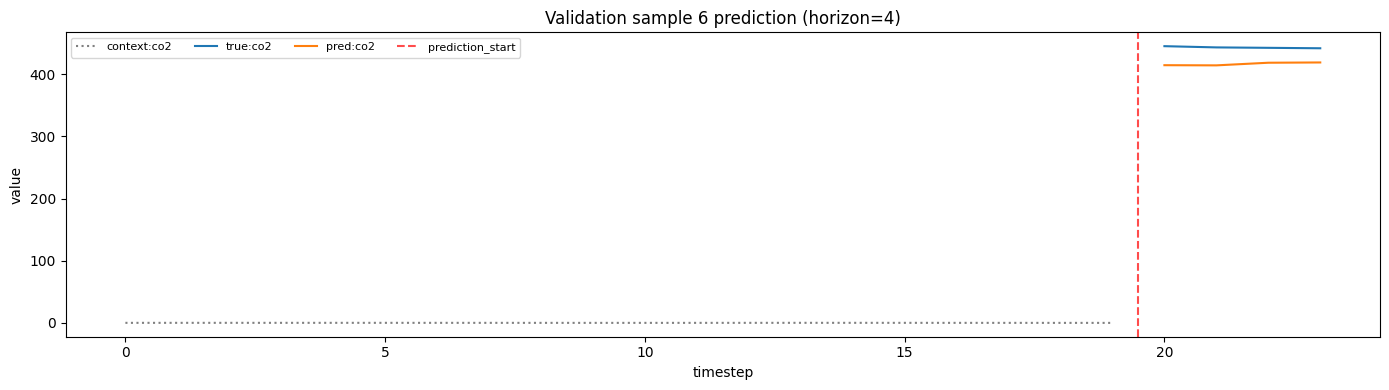

In [44]:
# Validation sample predictions visualization with 20 timesteps of context before prediction
import numpy as np
import matplotlib.pyplot as plt

model.eval()

# pick a few random validation samples
rng = np.random.default_rng(2343)
num_show = 6
indices_to_plot = rng.choice(len(val_set), size=min(num_show, len(val_set)), replace=False)

# helpers for (optional) de-normalization
norm_mean = getattr(dataset, "_norm_mean", None)
norm_std = getattr(dataset, "_norm_std", None)

plot_metrics = [
    "co2",
    "gas_resistance",
    "temperature",
    "humidity",
    "pressure",
    "light",
    "uv_index",
    "voc_equivalent",
]
metric_to_idx = {name: i for i, name in enumerate(dataset._metric_names)}

CONTEXT_TO_SHOW = 20

for i, local_idx in enumerate(indices_to_plot, start=1):
    # Try to recover the context input to prediction, if available.
    # val_set[local_idx][0] is (window, INPUT_DIM), val_set[local_idx][1] is (horizon, OUTPUT_DIM)
    x, y_true = val_set[local_idx]

    # Try to get indices in underlying dataframe, fallback: use just x (model input)
    context_x = None
    context_used = False

    if hasattr(val_set, '_indices') and hasattr(val_set, '_df'):
        # Custom Dataset-type handling: try to extract context from _df using indices
        idx = val_set._indices[local_idx] if hasattr(val_set, '_indices') else local_idx
        window = x.shape[0] if len(x.shape) > 1 else len(x)
        start_in_df = idx  # the index of where this window starts
        context_start = max(0, start_in_df - CONTEXT_TO_SHOW)
        context_end = start_in_df  # not inclusive (until immediately before prediction window)
        context_rows = val_set._df.iloc[context_start:context_end]
        # Extract only metric columns from _df (handle missing cols)
        metric_cols = [col for col in plot_metrics if col in context_rows.columns]
        if len(metric_cols) > 0:
            context_x = context_rows[metric_cols].to_numpy()
            context_used = True
    if not context_used:
        # Use model input as context, but can't get more than window (no guarantee for extra context)
        if x.shape[0] >= CONTEXT_TO_SHOW:
            context_x = x[-CONTEXT_TO_SHOW:]
            context_used = True
        else:
            context_x = x
            context_used = True

    with torch.no_grad():
        y_pred = model(x.unsqueeze(0).to(DEVICE).float()).cpu().squeeze(0)

    # Optional de-normalization
    def denorm(arr, is_context=False):
        if norm_mean is not None and norm_std is not None:
            if OUTPUT_DIM == 1 and dataset._target_col is not None:
                col = dataset._target_col
                if not is_context:
                    return arr * norm_std[col] + norm_mean[col]
                # context_x is either np or torch; if shape mismatch, fallback to as is
                if arr.shape[1] == 1 and col < norm_mean.shape[0]:
                    return arr * norm_std[col] + norm_mean[col]
                # If context has all features, map appropriately
                return arr
            else:
                norm_std_tensor = torch.from_numpy(norm_std).float() if isinstance(arr, torch.Tensor) else norm_std
                norm_mean_tensor = torch.from_numpy(norm_mean).float() if isinstance(arr, torch.Tensor) else norm_mean
                return arr * norm_std_tensor + norm_mean_tensor
        else:
            return arr

    y_true_plot = denorm(y_true)
    y_pred_plot = denorm(y_pred)
    context_x_plot = denorm(context_x, is_context=True)

    # Plot a subset of metrics
    plt.figure(figsize=(14, 4))
    plotted_any = False
    for name in plot_metrics:
        if OUTPUT_DIM == 1 and dataset._target_col is not None:
            # Only target metric available in y
            if name == dataset._metric_names[dataset._target_col]:
                # Plot context before prediction (dotted line)
                if context_x_plot is not None and context_x_plot.shape[1] >= 1:
                    context_vals = context_x_plot[:, 0] if context_x_plot.shape[1] == 1 else context_x_plot[:, metric_to_idx.get(name, 0)]
                    plt.plot(
                        np.arange(CONTEXT_TO_SHOW), context_vals, 
                        label=f"context:{name}", linestyle='dotted', color='gray'
                    )
                # Plot true and predicted (solid lines)
                plt.plot(
                    np.arange(CONTEXT_TO_SHOW, CONTEXT_TO_SHOW + y_true_plot.shape[0]), 
                    y_true_plot.numpy()[:, 0], label=f"true:{name}", linestyle='solid'
                )
                plt.plot(
                    np.arange(CONTEXT_TO_SHOW, CONTEXT_TO_SHOW + y_pred_plot.shape[0]),
                    y_pred_plot.numpy()[:, 0], label=f"pred:{name}", linestyle='solid'
                )
                plotted_any = True
        else:
            if name in metric_to_idx:
                col = metric_to_idx[name]
                # Plot context before prediction (dotted line)
                if context_x_plot is not None and context_x_plot.shape[1] > col:
                    context_vals = context_x_plot[:, col]
                    plt.plot(
                        np.arange(CONTEXT_TO_SHOW), context_vals, 
                        label=f"context:{name}", linestyle='dotted', color='gray'
                    )
                # Plot true and predicted (solid lines)
                plt.plot(
                    np.arange(CONTEXT_TO_SHOW, CONTEXT_TO_SHOW + y_true_plot.shape[0]), 
                    y_true_plot.numpy()[:, col], label=f"true:{name}", linestyle='solid'
                )
                plt.plot(
                    np.arange(CONTEXT_TO_SHOW, CONTEXT_TO_SHOW + y_pred_plot.shape[0]),
                    y_pred_plot.numpy()[:, col], label=f"pred:{name}", linestyle='solid'
                )
                plotted_any = True
    if not plotted_any:
        # fallback: plot first few channels
        C = y_true_plot.shape[1]
        for col in range(min(3, C)):
            # context
            if context_x_plot is not None and context_x_plot.shape[1] > col:
                plt.plot(
                    np.arange(CONTEXT_TO_SHOW), context_x_plot[:, col], 
                    label=f"context:c{col}", linestyle='dotted', color='gray'
                )
            # true and pred
            plt.plot(
                np.arange(CONTEXT_TO_SHOW, CONTEXT_TO_SHOW + y_true_plot.shape[0]), 
                y_true_plot.numpy()[:, col], label=f"true:c{col}", linestyle='solid'
            )
            plt.plot(
                np.arange(CONTEXT_TO_SHOW, CONTEXT_TO_SHOW + y_pred_plot.shape[0]),
                y_pred_plot.numpy()[:, col], label=f"pred:c{col}", linestyle='solid'
            )

    # Indicate prediction start
    plt.axvline(CONTEXT_TO_SHOW - 0.5, color="red", linestyle="--", alpha=0.7, label="prediction_start")

    plt.title(f"Validation sample {i} prediction (horizon={HORIZON})")
    plt.xlabel("timestep")
    plt.ylabel("value")
    plt.legend(ncol=4, fontsize=8)
    plt.tight_layout()
    plt.show()
